#### Import packages and define functions

In [2]:
import numpy as np
import pandas as pd
import pandas as pd
import sklearn
import os
import re
import itertools
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import RocCurveDisplay
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split

In [3]:
def bool_to_int(sample, colname):
    def is_yes(a):
        if a == 'Yes':
            return 1
        else:
            return 0
    return sample[colname].apply(is_yes)

#### Load input CPG dataframes

Input dataframes are loaded in added to a dicctionary.

In [4]:
# List to iterate to create dicc dataframe
cancer_files = os.listdir("/home/amaqueda/TFM/ML_project/ML_part/input/",)
cancer_types = [re.sub("_lof.fisher.permutation_input.tsv", "", x) for x in cancer_files]


In [5]:
# Create empty dicc
CPGs_input_dicc = {}
for (name,file) in zip(cancer_types, cancer_files):
    CPGs_input_dicc[name] =  pd.read_table("/home/amaqueda/TFM/ML_project/ML_part/input/" + file, sep="\t", header=0)

In [6]:
# Select pancancer features and put genes as the index
CPG_input_pancancer = CPGs_input_dicc["PANCANCER"]
CPG_input_pancancer.index = CPG_input_pancancer["Gene"]
# CPG_input_pancancer.info()

# Drop unused features features.
CPG_input_pancancer_ML = CPG_input_pancancer.drop(columns = ["Gene", "PTM.exact_pval", "PTM.proximal_pval", "PTM.distal_pval",
                                                             "PTM_exact_pval_EUR", "PTM_proximal_pval_EUR", "PTM_distal_pval_EUR"])

for col in ["CPG","DNA_repair", "PIK_mTOR", "Cell_cycle", "Chromatin"]: 
    CPG_input_pancancer_ML[col] = bool_to_int(CPG_input_pancancer_ML, col)


CPG_input_pancancer_ML_FS = CPG_input_pancancer_ML.drop(columns = [s for s in CPG_input_pancancer_ML.columns if "min" in s] +
                             ["amplification.freq", "deletion.freq"] +
                            #  ["avg_ALL"] +
                             ["avg_CPG", "avg_DNA_repair", "avg_PIK_mTOR", "avg_Cell_Cycle", "avg_Chromatin_Remodeling"] +
                             ["DNA_repair", "PIK_mTOR", "Cell_cycle", "Chromatin"] +
                             ["tau_tissue_specificity", "num.PTV_mutations", "interaction_estimate_EUR", "z_value_EUR"] +
                             ["interaction_estimate_loh_germ_glm", "z_value_loh_germ_glm"] +
                             ["oe_lof_upper"] + [s for s in CPG_input_pancancer_ML.columns if "all_types" in s] +
                             ["clinvar.germline.freq", "delmis.germline.freq", "plof.germline.freq",
                              "clinvar.gnomAD_AF", "delmis.gnomAD_AF", "plof.gnomAD_AF"] +
                             [s for s in CPG_input_pancancer_ML.columns if "germline" in s] +
                             [s for s in CPG_input_pancancer_ML.columns if "fish" in s])
CPG_input_pancancer_ML_FS.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18464 entries, A1BG to DUX4L2
Data columns (total 15 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   gain+amplification.freq      17633 non-null  float64
 1   loss+deletion.freq           17633 non-null  float64
 2   tau_cancer_type_specificity  16046 non-null  float64
 3   delmis.gnomAD_AF_EUR         17340 non-null  float64
 4   plof.gnomAD_AF_EUR           17340 non-null  float64
 5   clinvar.gnomAD_AF_EUR        17340 non-null  float64
 6   p_value_EUR                  16489 non-null  float64
 7   num.somatic_mutation         17183 non-null  float64
 8   PTV_frequency                17183 non-null  float64
 9   CPG                          18464 non-null  int64  
 10  avg_ALL                      8993 non-null   float64
 11  oe_lof                       16506 non-null  float64
 12  permut_exact_pval            16167 non-null  float64
 13  permut_proximal_p

### NA TO MEANS

In [7]:
distances_cols = [s for s in CPG_input_pancancer_ML_FS.columns if ("avg" in s)]

In [8]:
cpgs = CPG_input_pancancer_ML_FS[CPG_input_pancancer_ML_FS['CPG'] == 1]
for col in distances_cols:
    cpgs[col].replace(np.nan, cpgs[col].mean(), inplace=True) 
cpgs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 152 entries, ABCB11 to XPC
Data columns (total 15 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   gain+amplification.freq      144 non-null    float64
 1   loss+deletion.freq           144 non-null    float64
 2   tau_cancer_type_specificity  141 non-null    float64
 3   delmis.gnomAD_AF_EUR         145 non-null    float64
 4   plof.gnomAD_AF_EUR           145 non-null    float64
 5   clinvar.gnomAD_AF_EUR        145 non-null    float64
 6   p_value_EUR                  144 non-null    float64
 7   num.somatic_mutation         149 non-null    float64
 8   PTV_frequency                149 non-null    float64
 9   CPG                          152 non-null    int64  
 10  avg_ALL                      152 non-null    float64
 11  oe_lof                       143 non-null    float64
 12  permut_exact_pval            138 non-null    float64
 13  permut_proximal_pval

/tmp/ipykernel_4909/1429412293.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cpgs[col].replace(np.nan, cpgs[col].mean(), inplace=True)


In [9]:
random_genes = CPG_input_pancancer_ML_FS[CPG_input_pancancer_ML_FS['CPG'] == 0]
for col in distances_cols:
    random_genes[col].replace(np.nan, random_genes[col].mean(), inplace=True) 
random_genes.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18312 entries, A1BG to DUX4L2
Data columns (total 15 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   gain+amplification.freq      17489 non-null  float64
 1   loss+deletion.freq           17489 non-null  float64
 2   tau_cancer_type_specificity  15905 non-null  float64
 3   delmis.gnomAD_AF_EUR         17195 non-null  float64
 4   plof.gnomAD_AF_EUR           17195 non-null  float64
 5   clinvar.gnomAD_AF_EUR        17195 non-null  float64
 6   p_value_EUR                  16345 non-null  float64
 7   num.somatic_mutation         17034 non-null  float64
 8   PTV_frequency                17034 non-null  float64
 9   CPG                          18312 non-null  int64  
 10  avg_ALL                      18312 non-null  float64
 11  oe_lof                       16363 non-null  float64
 12  permut_exact_pval            16029 non-null  float64
 13  permut_proximal_p

/tmp/ipykernel_4909/282186606.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  random_genes[col].replace(np.nan, random_genes[col].mean(), inplace=True)


In [10]:
CPG_input_pancancer_ML_FS_mean = pd.concat([cpgs, random_genes])

# Drop NAs
CPG_input_pancancer_ML_FS_mean_NA = CPG_input_pancancer_ML_FS_mean.dropna()

# Check shapes
print(CPG_input_pancancer_ML_FS_mean.shape)
print(CPG_input_pancancer_ML_FS_mean_NA.shape)

# Check lost CPGs
print("Lost CPGs: " + str(CPG_input_pancancer_ML_FS_mean["CPG"].sum() - CPG_input_pancancer_ML_FS_mean_NA["CPG"].sum()))

(18464, 15)
(13954, 15)
Lost CPGs: 23


In [13]:
import random

# Get fixed random genes (not related to cancer to train a balanced model.
CPG = list(CPG_input_pancancer_ML["CPG"][CPG_input_pancancer_ML["CPG"] == 1].index) # Get CPGs
SOD = [line.strip() for line in open("/home/amaqueda/TFM/ML_project/ML_part/input/CGC_driver_genes.txt", "r").readlines()] # Get SOD
cancer_genes = sorted(set(CPG + SOD)) 

# All random genes
# All genes in dataframe removing CPGs and SOD
random_genes = list(set(list(CPG_input_pancancer_ML_FS_mean_NA.index)) - set(cancer_genes) - set(['CDRT1']))

# There are X CPGs in the CPG_pancan_EUR_max datarame, select the same number of random genes
random.seed(42)
sample_random_genes = random.sample(random_genes, int(CPG_input_pancancer_ML_FS_mean_NA["CPG"].sum()))

# Combine all the genes to have "N CPGs + N random" genes that are going to be the input
training_genes = sample_random_genes + list(CPG_input_pancancer_ML_FS_mean_NA["CPG"][CPG_input_pancancer_ML_FS_mean_NA["CPG"] == 1].index)

### Start Machine Learning Classifier approach

In this part of the notebook I've tried to fit some classifiers based on the most common approaches in ML.

1. All the packages are imported.
2. Genes were subseted in order to get a balanced CPG-random dataframe.
3. Features and target label were separed in X and y repectively.
4. X and y were divided in training set 80% (trainig and hyperparameter tunning) and test 20% (evaluating best model).

In [14]:
# All the neccesary functions
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, RocCurveDisplay
from sklearn.linear_model import RidgeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC

# Select ML input df.
ML_input_df = CPG_input_pancancer_ML_FS_mean_NA.loc[training_genes,]

# Define X and y
X = ML_input_df.drop(columns = "CPG")
y = ML_input_df["CPG"]

# Define train (input for fitting the model (and hyperparameter tunning) and test (best model evaluation).
X_train, X_test,y_train, y_test =  train_test_split(X, y, random_state = 1, test_size = 0.2)

#### **Dummy Classifier**

Accuracy: 0.4423076923076923
              precision    recall  f1-score   support

           0       0.56      0.65      0.60        23
           1       0.68      0.59      0.63        29

    accuracy                           0.62        52
   macro avg       0.62      0.62      0.61        52
weighted avg       0.62      0.62      0.62        52

Tuned Model Parameters: {'dummy__strategy': 'uniform'}


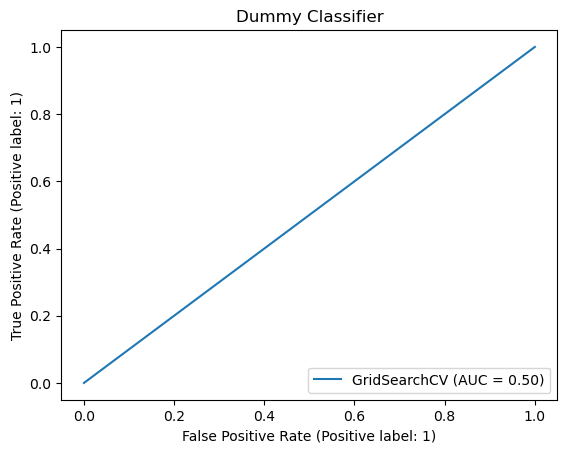

Index(['gain+amplification.freq', 'loss+deletion.freq',
       'tau_cancer_type_specificity', 'delmis.gnomAD_AF_EUR',
       'plof.gnomAD_AF_EUR', 'clinvar.gnomAD_AF_EUR', 'p_value_EUR',
       'num.somatic_mutation', 'PTV_frequency', 'avg_ALL', 'oe_lof',
       'permut_exact_pval', 'permut_proximal_pval', 'permut_distal_pval'],
      dtype='object')


In [18]:
## Dummy Classifier
steps_dummy = [("scaler", StandardScaler()),
         ("dummy", DummyClassifier())]
pipeline_dummy = Pipeline(steps_dummy)

# Specify the hyperparameter space
parameters_dummy = {'dummy__strategy':['prior', 'stratified', 'uniform']}
dummy_grid_cv = GridSearchCV(pipeline_dummy, parameters_dummy, cv=5)
dummy_grid_cv.fit(X_train, y_train)

y_pred_dummy = dummy_grid_cv.predict(X_test)

# Compute and print metrics
print("Accuracy: {}".format(dummy_grid_cv.score(X_test, y_test)))
print(classification_report(y_test, y_pred_dummy))
print("Tuned Model Parameters: {}".format(dummy_grid_cv.best_params_))

svc_disp = RocCurveDisplay.from_estimator(dummy_grid_cv, X_test, y_test)
plt.title("Dummy Classifier")
# plt.savefig('/media/mmoradiellos/LaCie1/CPG_project/scripts_to_do_ML_models/good_scripts/plots/dummy_classifier_auc.pdf', dpi = 300)
plt.show()

print(X_test.columns)


#### **Ridge Classifier**

Accuracy: 0.8269230769230769
              precision    recall  f1-score   support

           0       0.73      0.96      0.83        23
           1       0.95      0.72      0.82        29

    accuracy                           0.83        52
   macro avg       0.84      0.84      0.83        52
weighted avg       0.86      0.83      0.83        52

Tuned Model Parameters: {'LRC__alpha': 0.001}


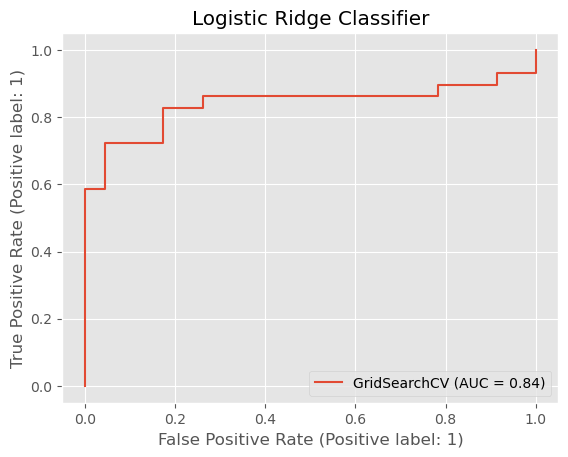

Index(['gain+amplification.freq', 'loss+deletion.freq',
       'tau_cancer_type_specificity', 'delmis.gnomAD_AF_EUR',
       'plof.gnomAD_AF_EUR', 'clinvar.gnomAD_AF_EUR', 'p_value_EUR',
       'num.somatic_mutation', 'PTV_frequency', 'avg_ALL', 'oe_lof',
       'permut_exact_pval', 'permut_proximal_pval', 'permut_distal_pval'],
      dtype='object')


In [37]:
## Ridge Classifier
steps_LRC = [("scaler", StandardScaler()),
         ("LRC", RidgeClassifier())]
pipeline_LRC = Pipeline(steps_LRC)

# Specify the hyperparameter space
parameters_LRC = {'LRC__alpha':[0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]}
lrc_grid_cv = GridSearchCV(pipeline_LRC, parameters_LRC, cv=5)
lrc_grid_cv.fit(X_train, y_train)

y_pred_rc = lrc_grid_cv.predict(X_test)

# Compute and print metrics
print("Accuracy: {}".format(lrc_grid_cv.score(X_test, y_test)))
print(classification_report(y_test, y_pred_rc))
print("Tuned Model Parameters: {}".format(lrc_grid_cv.best_params_))


svc_disp = RocCurveDisplay.from_estimator(lrc_grid_cv, X_test, y_test)
plt.title("Logistic Ridge Classifier")
# plt.savefig('/media/mmoradiellos/LaCie1/CPG_project/scripts_to_do_ML_models/good_scripts/plots/ridgeclassifier_auc.pdf', dpi = 300)
plt.show()

print(X_test.columns)


#### **Random Forest**

In [24]:
## Random forest
steps_RFC = [("RFC", RandomForestClassifier())]
pipeline_RFC = Pipeline(steps_RFC)

# Specify the hyperparameter space
parameters_RFC = {'RFC__n_estimators':[100,200], # numeros bajos,
                  'RFC__min_samples_split': [2, 3, 4, 5, 6, 7, 10]}
'''
parameters_RFC = {'RFC__bootstrap': [True, False],
 'RFC__max_depth': [20, 40, 60, 80, 100, None],
 'RFC__max_features': ['auto', 'sqrt'],
 'RFC__min_samples_leaf': [1, 2, 4],
 'RFC__min_samples_split': [2, 5, 10],
 'RFC__n_estimators': [1000, 1500, 2000]}
'''
rfc_grid_cv = GridSearchCV(pipeline_RFC, parameters_RFC, cv=5)
rfc_grid_cv.fit(X_train, y_train)

y_pred_rf = rfc_grid_cv.predict(X_test)

# Compute and print metrics
print("Accuracy: {}".format(rfc_grid_cv.score(X_test, y_test)))
print(classification_report(y_test, y_pred_rf))
print("Tuned Model Parameters: {}".format(rfc_grid_cv.best_params_))

print(rfc_grid_cv.best_params_)


Accuracy: 0.8653846153846154
              precision    recall  f1-score   support

           0       0.77      1.00      0.87        23
           1       1.00      0.76      0.86        29

    accuracy                           0.87        52
   macro avg       0.88      0.88      0.87        52
weighted avg       0.90      0.87      0.87        52

Tuned Model Parameters: {'RFC__min_samples_split': 10, 'RFC__n_estimators': 200}
{'RFC__min_samples_split': 10, 'RFC__n_estimators': 200}


Accuracy: 0.875
              precision    recall  f1-score   support

         0.0       0.91      0.83      0.87        36
         1.0       0.85      0.92      0.88        36

    accuracy                           0.88        72
   macro avg       0.88      0.88      0.87        72
weighted avg       0.88      0.88      0.87        72



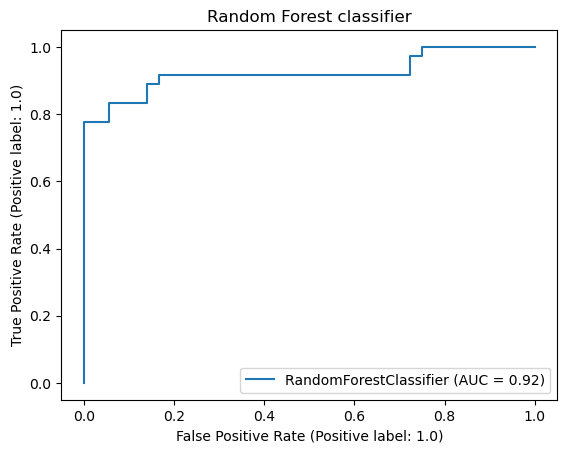

Index(['amplification.freq', 'gain+amplification.freq', 'loss+deletion.freq',
       'deletion.freq', 'tau_tissue_specificity',
       'tau_cancer_type_specificity', 'pLI', 'Avg_DNA_repair', 'Avg_PIK_mTOR',
       'Avg_Cell_cycle', 'Avg_Chromatin', 'clinvar.germline.freq.EUR',
       'delmis.germline.freq.EUR', 'plof.germline.freq.EUR',
       'delmis.gnomAD_AF_EUR', 'plof.gnomAD_AF_EUR', 'clinvar.gnomAD_AF_EUR',
       'PTM_distal_pval_EUR', 'PTM_exact_pval_EUR', 'PTM_proximal_pval_EUR',
       'interaction_estimate_EUR', 'z_value_EUR'],
      dtype='object')


In [16]:
## Random forest

X_final = X.drop(columns=['PTM.distal_pval', 'PTM.exact_pval', 'PTM.proximal_pval', 'interaction_estimate_loh_germ_glm', 'z_value_loh_germ_glm'])
X_train, X_test,y_train, y_test =  train_test_split(X_final, y, random_state = 101, test_size = 0.3)


RFC = RandomForestClassifier(bootstrap=True, max_depth=40, max_features="sqrt",
                             min_samples_leaf=2, min_samples_split=5, n_estimators = 1500)


RFC.fit(X_train, y_train)

y_pred_rf = RFC.predict(X_test)

# Compute and print metrics
print("Accuracy: {}".format(RFC.score(X_test, y_test)))
print(classification_report(y_test, y_pred_rf))


svc_disp = RocCurveDisplay.from_estimator(RFC, X_test, y_test)
plt.title("Random Forest classifier")
plt.savefig('/media/mmoradiellos/LaCie1/CPG_project/scripts_to_do_ML_models/good_scripts/plots/randomforest_auc.pdf', dpi = 300)
plt.show()

print(X_test.columns)


#### **SVC**

Accuracy: 0.7884615384615384
              precision    recall  f1-score   support

           0       0.71      0.87      0.78        23
           1       0.88      0.72      0.79        29

    accuracy                           0.79        52
   macro avg       0.79      0.80      0.79        52
weighted avg       0.80      0.79      0.79        52

Tuned Model Parameters: {'SVC__C': 10, 'SVC__gamma': 0.01, 'SVC__kernel': 'sigmoid'}


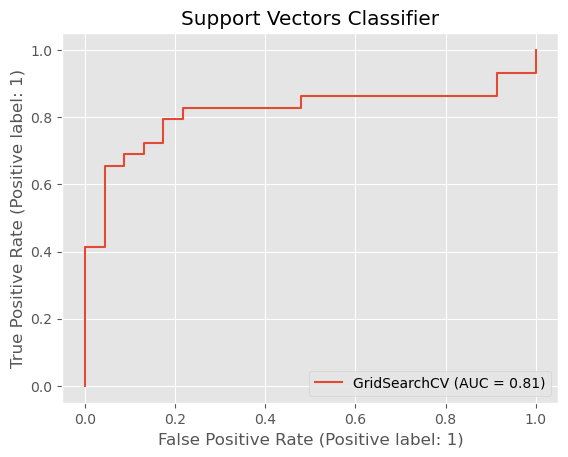

In [30]:
# SVM 
steps_SVC = [("scaler", StandardScaler()),
         ("SVC", SVC())]
pipeline_SVC = Pipeline(steps_SVC)

# Specify the hyperparameter space
parameters_SVC = {'SVC__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                  'SVC__C': [0.1, 1, 10, 100],
                  'SVC__gamma': [10, 1, 0.1, 0.01, 0.001, 0.0001]}

svc_grid_cv = GridSearchCV(pipeline_SVC, parameters_SVC, cv=5)
svc_grid_cv.fit(X_train, y_train)

y_pred_svc = svc_grid_cv.predict(X_test)

# Compute and print metrics
print("Accuracy: {}".format(svc_grid_cv.score(X_test, y_test)))
print(classification_report(y_test, y_pred_svc))
print("Tuned Model Parameters: {}".format(svc_grid_cv.best_params_))

svc_disp = RocCurveDisplay.from_estimator(svc_grid_cv, X_test, y_test)
plt.title("Support Vectors Classifier")

plt.show()


#### **KNN**

Accuracy: 0.75

               precision    recall  f1-score   support

           0       0.65      0.96      0.77        23
           1       0.94      0.59      0.72        29

    accuracy                           0.75        52
   macro avg       0.80      0.77      0.75        52
weighted avg       0.81      0.75      0.74        52

Tuned Model Parameters: {'KNN__n_neighbors': 5, 'KNN__weights': 'uniform'}


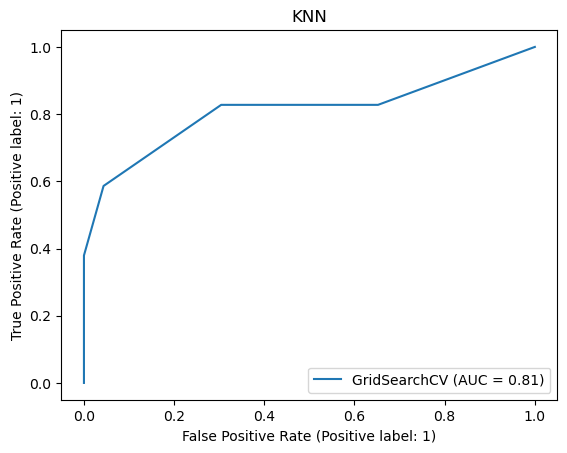

Index(['gain+amplification.freq', 'loss+deletion.freq',
       'tau_cancer_type_specificity', 'delmis.gnomAD_AF_EUR',
       'plof.gnomAD_AF_EUR', 'clinvar.gnomAD_AF_EUR', 'p_value_EUR',
       'num.somatic_mutation', 'PTV_frequency', 'avg_ALL', 'oe_lof',
       'permut_exact_pval', 'permut_proximal_pval', 'permut_distal_pval'],
      dtype='object')


In [15]:
from sklearn.neighbors import KNeighborsClassifier


steps_KNN = [("scaler", StandardScaler()),
         ("KNN", KNeighborsClassifier())]
pipeline_KNN = Pipeline(steps_KNN)

# Specify the hyperparameter space
parameters_KNN = {'KNN__weights' : ['uniform', 'distance'],
                  'KNN__n_neighbors': [2, 3, 4, 5, 6, 7],
                  }

knn_grid_cv = GridSearchCV(pipeline_KNN, parameters_KNN, cv=5)
knn_grid_cv.fit(X_train, y_train)

y_pred_knn = knn_grid_cv.predict(X_test)

# Compute and print metrics
print("Accuracy: {}".format(knn_grid_cv.score(X_test, y_test)))
print('\n', classification_report(y_test, y_pred_knn))
print("Tuned Model Parameters: {}".format(knn_grid_cv.best_params_))

svc_disp = RocCurveDisplay.from_estimator(knn_grid_cv, X_test, y_test)
plt.title("KNN")

plt.show()

print(X_test.columns)


### Check PCAs

In [26]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
import statsmodels.api as sm

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
import matplotlib.font_manager
from matplotlib import style
style.use('ggplot') or plt.style.use('ggplot')

# Preprocesado y modelado
# ==============================================================================
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale
import seaborn as sns

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')



(52, 7)


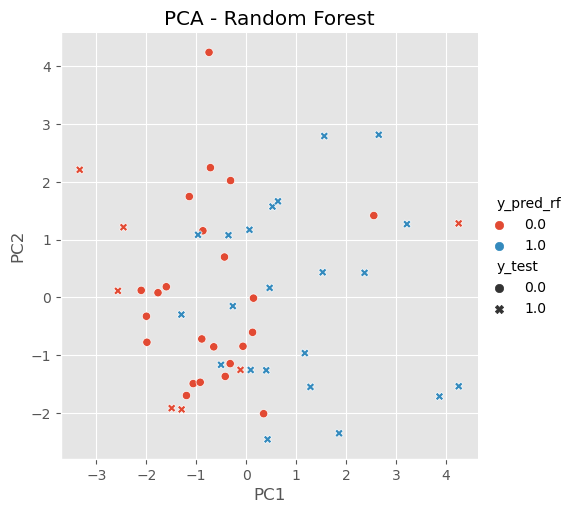

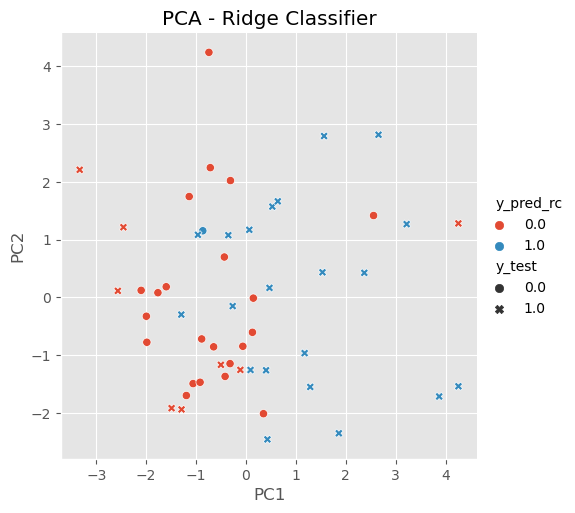

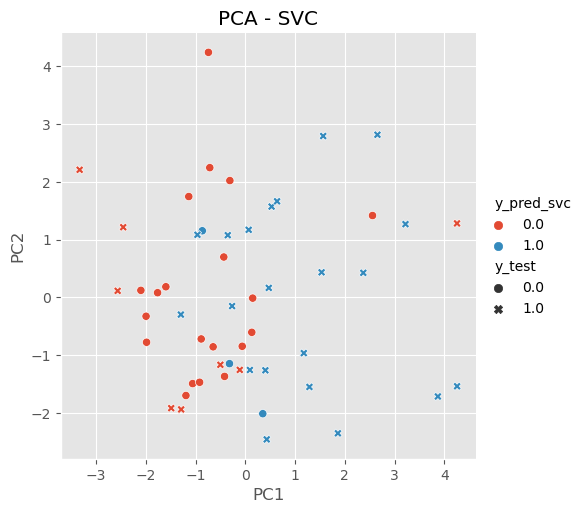

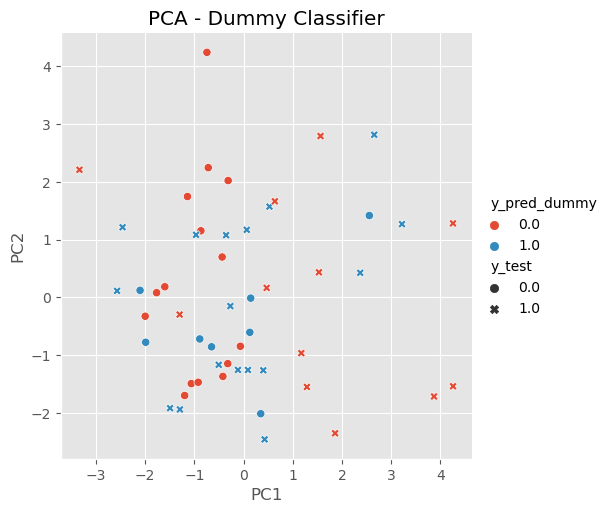

In [27]:
steps_PCA = [("scaler", StandardScaler()),
         ("PCA", PCA(n_components = 2))]
pipeline_PCA = Pipeline(steps_PCA)

PCA_df = pipeline_PCA.fit_transform(X_test)

# Se extrae el modelo entrenado del pipeline

PCA_df = pd.DataFrame(np.column_stack((PCA_df, y_test, y_pred_rf, y_pred_dummy, y_pred_rc, y_pred_svc)))
PCA_df.index = y_test.index
print(PCA_df.shape)
PCA_df.columns = ['PC1', 'PC2', 'y_test', 'y_pred_rf', 'y_pred_dummy', 'y_pred_rc', 'y_pred_svc']

sns.relplot(data=PCA_df, x='PC1', y='PC2', hue='y_pred_rf', style = 'y_test').set(title='PCA - Random Forest')
sns.relplot(data=PCA_df, x='PC1', y='PC2', hue='y_pred_rc', style = 'y_test').set(title='PCA - Ridge Classifier')
sns.relplot(data=PCA_df, x='PC1', y='PC2', hue='y_pred_svc', style = 'y_test').set(title='PCA - SVC')
sns.relplot(data=PCA_df, x='PC1', y='PC2', hue='y_pred_dummy', style = 'y_test').set(title='PCA - Dummy Classifier')

## ROC curve
This cell explains the ROC curve and the area under ROC curve.
A Receiver Operator Characteristic (ROC) curve is a graphical plot used to show the diagnostic ability of binary classifiers. 
It takes into account the FP rate and the TP rate.

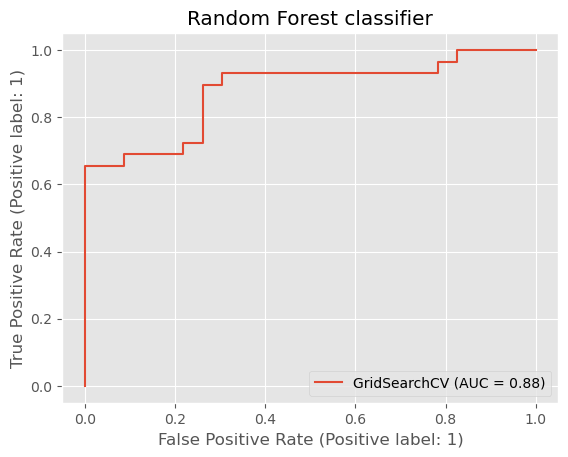

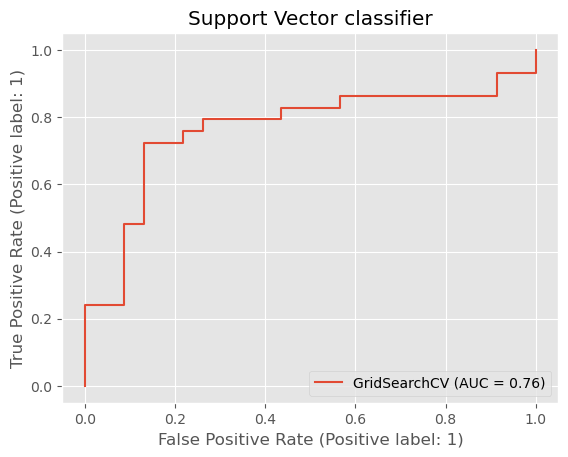

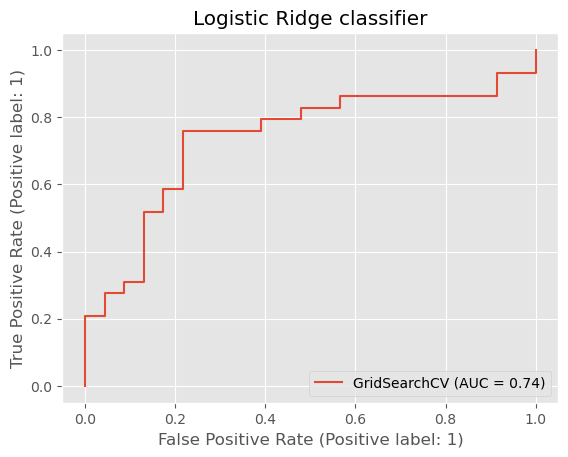

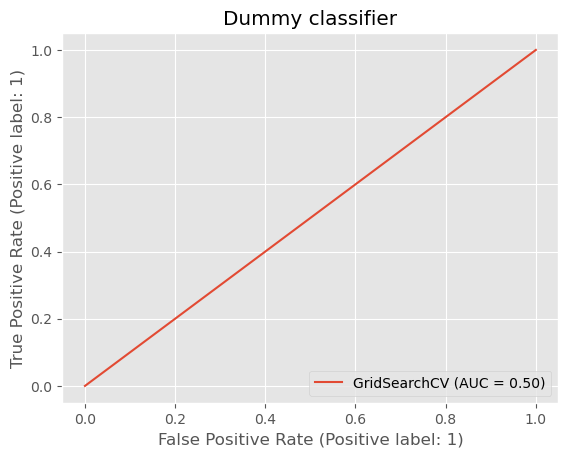

In [61]:
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import RocCurveDisplay
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split

# svc_disp = RocCurveDisplay.from_estimator(RFC, X_test, y_test)
svc_disp = RocCurveDisplay.from_estimator(rfc_grid_cv, X_test, y_test)
plt.title("Random Forest classifier")
plt.show()

svc_disp = RocCurveDisplay.from_estimator(svc_grid_cv, X_test, y_test)
plt.title("Support Vector classifier")
plt.show()

svc_disp = RocCurveDisplay.from_estimator(lrc_grid_cv, X_test, y_test)
plt.title("Logistic Ridge classifier")
plt.show()

svc_disp = RocCurveDisplay.from_estimator(dummy_grid_cv, X_test, y_test)
plt.title("Dummy classifier")
plt.show()

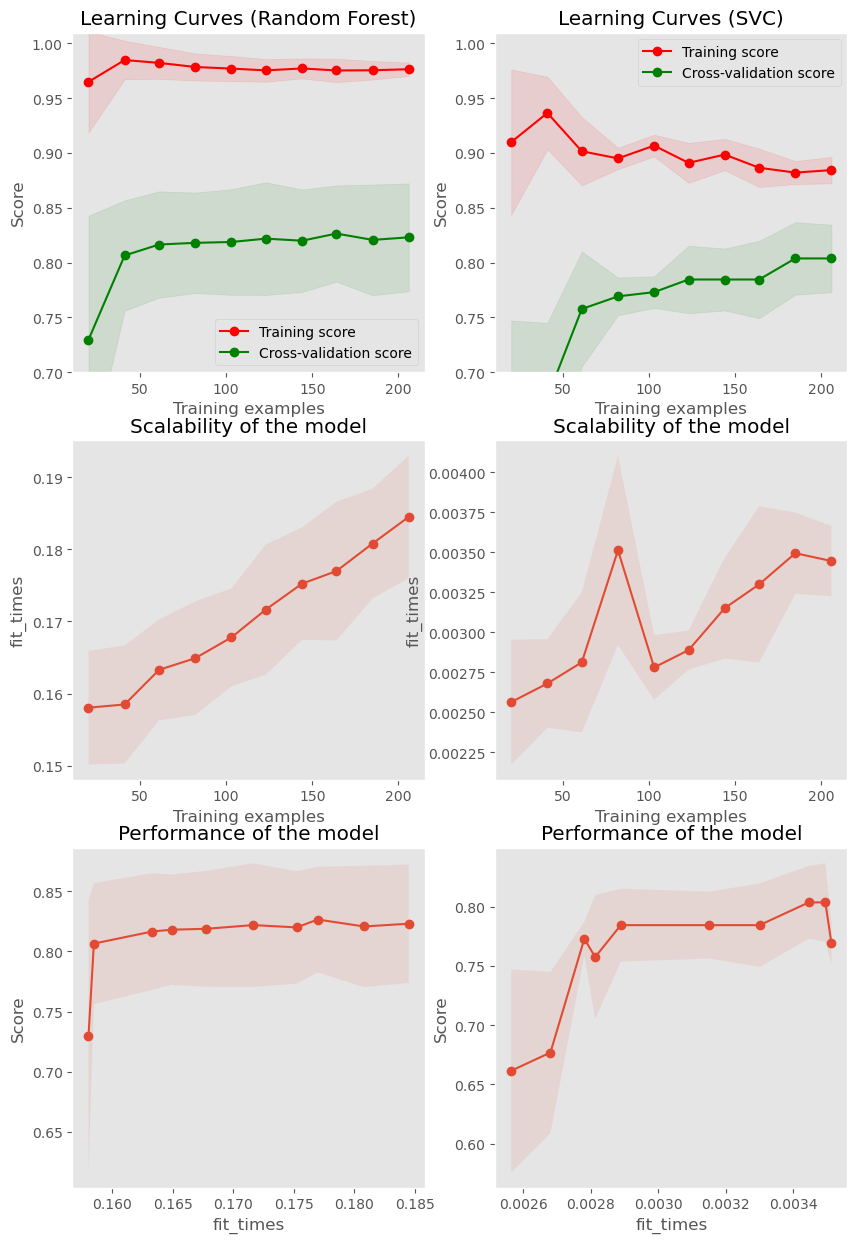

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=None,
    ylim=None,
    cv=None,
    n_jobs=None,
    train_sizes=np.linspace(0.1, 1.0, 10),
):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes[0].plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
    )
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    fit_time_argsort = fit_times_mean.argsort()
    fit_time_sorted = fit_times_mean[fit_time_argsort]
    test_scores_mean_sorted = test_scores_mean[fit_time_argsort]
    test_scores_std_sorted = test_scores_std[fit_time_argsort]
    axes[2].grid()
    axes[2].plot(fit_time_sorted, test_scores_mean_sorted, "o-")
    axes[2].fill_between(
        fit_time_sorted,
        test_scores_mean_sorted - test_scores_std_sorted,
        test_scores_mean_sorted + test_scores_std_sorted,
        alpha=0.1,
    )
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt


fig, axes = plt.subplots(3, 2, figsize=(10, 15))


title = "Learning Curves (Random Forest)"
# Cross validation with 50 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=50, test_size=0.2, random_state=42)

steps_RFC_estimator = [("scaler", StandardScaler()),
         ("RFC", RandomForestClassifier(min_samples_split = rfc_grid_cv.best_params_['RFC__min_samples_split'],
                                        n_estimators = rfc_grid_cv.best_params_['RFC__n_estimators']))]
pipeline_RFC_estimator = Pipeline(steps_RFC_estimator)

plot_learning_curve(
    pipeline_RFC_estimator, title, X, y, axes=axes[:, 0], ylim=(0.7, 1.01), cv=cv, n_jobs=4
)

title = r"Learning Curves (SVC)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

steps_SVC_estimator = [("scaler", StandardScaler()),
         ("SVC", SVC(C = svc_grid_cv.best_params_['SVC__C'],
                     gamma = svc_grid_cv.best_params_['SVC__gamma']))]
pipeline_SVC_estimator = Pipeline(steps_SVC_estimator)

plot_learning_curve(
    pipeline_SVC_estimator, title, X, y, axes=axes[:, 1], ylim=(0.7, 1.01), cv=cv, n_jobs=4
)

plt.show()

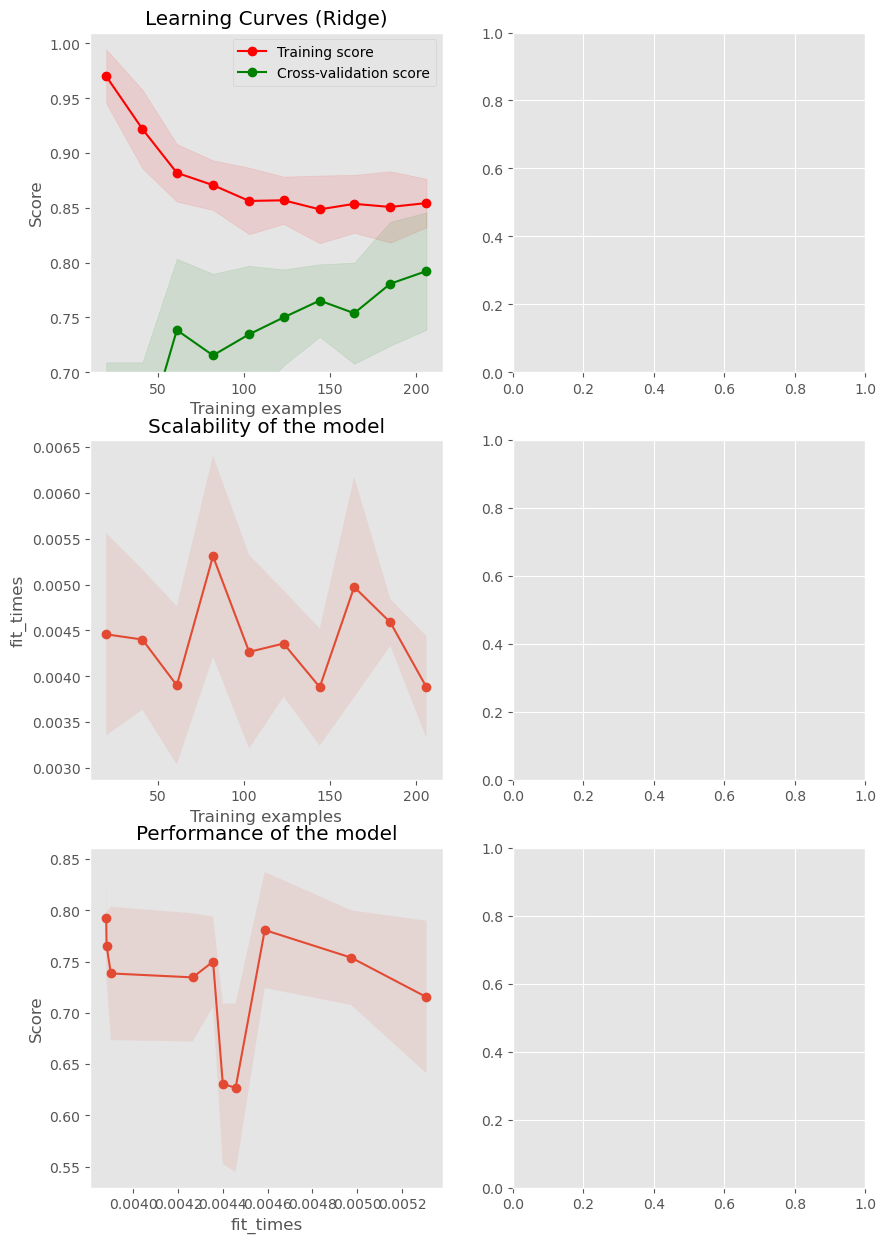

In [39]:
fig, axes = plt.subplots(3, 2, figsize=(10, 15))

title = r"Learning Curves (Ridge)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

steps_LRC_estimator = [("scaler", StandardScaler()),
         ("LRC", RidgeClassifier(alpha = lrc_grid_cv.best_params_['LRC__alpha']))]
pipeline_LRC_estimator = Pipeline(steps_LRC_estimator)

plot_learning_curve(
    pipeline_LRC_estimator, title, X, y, axes=axes[:, 0], ylim=(0.7, 1.01), cv=cv, n_jobs=4
)

plt.show()